In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset/")

Skipping, found downloaded files in "./twitter-tweets-sentiment-dataset" (use force=True to force download)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Input, Dropout, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Concatenate, Subtract, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.regularizers import l2 
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers.legacy import Adam

# Dataset

The dataset consists of tweets and their classified sentiment (Postive, Negative, and Neutral). It also provides a `selected_text` which is the word or phrase encapsulating the provided sentiment. 

Business case: Ability to detect negative tweets which could help in the process of blocking such tweets. For this case we will say that the result classification will not result in automatic blocking of the tweet but rather first step in review process of someones account. I.E. it could be such that if someone triggers more than X number of negative tweets; a review of the account starts. 

In [4]:
DATASET_PATH = "./twitter-tweets-sentiment-dataset"
TRAINING_CSV = "Tweets.csv"

df_training = pd.read_csv("{}/{}".format(DATASET_PATH, TRAINING_CSV))

In [5]:
df_training.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


***Initial clean up:***
* Remove `selected_text` as we want to train our model on the `text` to predict the `sentiment` 
* Remove `textID` as it will not contribute anything to the model


In [6]:
df_training.drop('textID', axis=1, inplace=True)
df_training.drop('selected_text', axis=1, inplace=True)
df_training['text'] = df_training['text'].astype(str)

In [7]:
df_training.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [8]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27481 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


* Data consist of 27,481 non null tweets and sentiments.

In [9]:
print('Sentiments are: ', df_training['sentiment'].unique())

Sentiments are:  ['neutral' 'negative' 'positive']


In [10]:
map_sentiment = {'neutral':0, 'negative':1, 'positive':2}
target_names = ['neutral', 'negative', 'positive']
df_training['sentiment'] = df_training['sentiment'].map(map_sentiment)

In [11]:
idx = round(np.random.rand()*len(df_training))
print('--------Random Tweet---------')
print('================================')
print('Tweet Sentiment: ',target_names[df_training.iloc[idx].sentiment])
print('================================')
print("\n".join(df_training.iloc[idx].text.split("\n")))

--------Random Tweet---------
Tweet Sentiment:  negative
Sad face moment of the day


## Tokenization

### Word Max Length

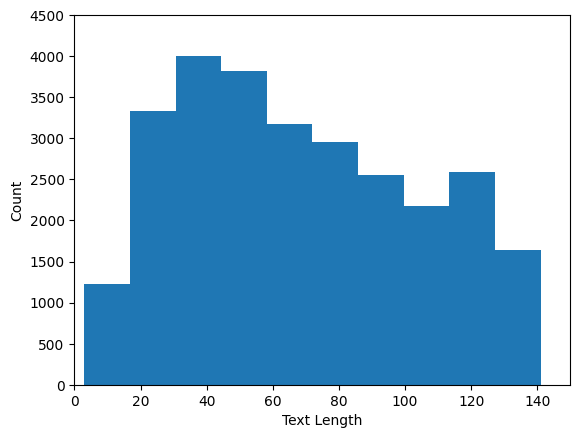

In [12]:
lengths = df_training.text.str.len()
plot.hist(lengths) 
plot.axis([0,150,0,4500])
plot.xlabel('Text Length')
plot.ylabel('Count')
plot.show()

In [13]:
print("Max length is {}".format(max(lengths)))
print("Min length is {}".format(min(lengths)))
print("Top 10 lengths: ", lengths.value_counts().nlargest(10).to_dict())

Max length is 141
Min length is 3
Top 10 lengths:  {41: 308, 48: 301, 46: 301, 42: 298, 45: 295, 44: 294, 36: 293, 34: 292, 39: 291, 43: 291}


From the graph above we can see that the maximum length is `140` and majority of given data length is in the range of `41-43`. Now if the maximum text length was a large number then going for the common length would be really helpful in reducing overhead in training. However, since the maximum length `140` is such a small number we will set the number of maximum number of words to `140`

In [14]:
%%time

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 140 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df_training.text)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df_training.text)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))

print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(df_training.sentiment)

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)

print(np.max(X))

Found 26598 unique tokens. Distilled to 26598 top words.
Shape of data tensor: (27481, 140)
Shape of label tensor: (27481, 3)
26598
CPU times: user 597 ms, sys: 13 ms, total: 610 ms
Wall time: 609 ms


## Metric

Detecting negative tweets correctly is very important. Similar to a medical diagnosis application, or detecting spam emails we care more about recall than percision. Will utilize ***F1_Beta*** score with giving recall twice the importance

Note:
* ***Accuracy*** While it provides an estimate of the overall model quality, it ignores the cost of misclassification, thus it could be misleading! Espcially when wanting to detect the type of fungi for treating patients.
* ***Percision*** Measuring the model's ability to identify instances of a particular class correctly.
* ***Recall*** Measuring the model's ability to identify all instances of a particular class.

## Data Split

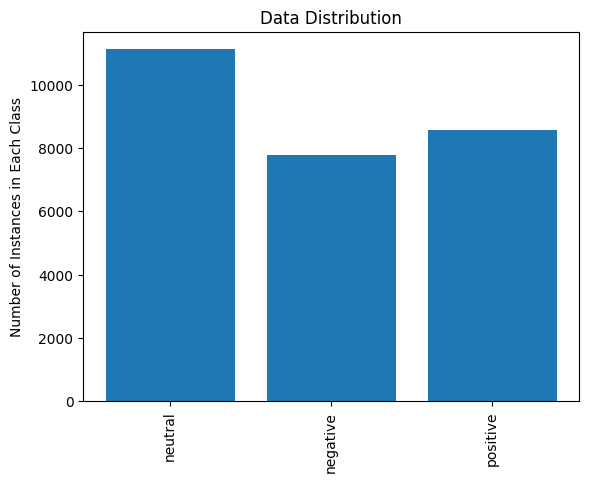

In [15]:
NUM_CLASSES = 3

uniq_classes = np.sum(y_ohe, axis=0)
plt.bar(list(range(NUM_CLASSES)),uniq_classes)
plt.xticks(list(range(NUM_CLASSES)), target_names, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.title("Data Distribution")
plt.show()

From the data distribution plot we can see that we have close number of `positive` and `negative` instances. We do have more `neutral` cases than both `negative` and `positive`. However, since we have `27,481` instances it will be safe for us to go with an `80/20` split.

X_train Shape: (21984, 140) Label Shape: (21984, 3)


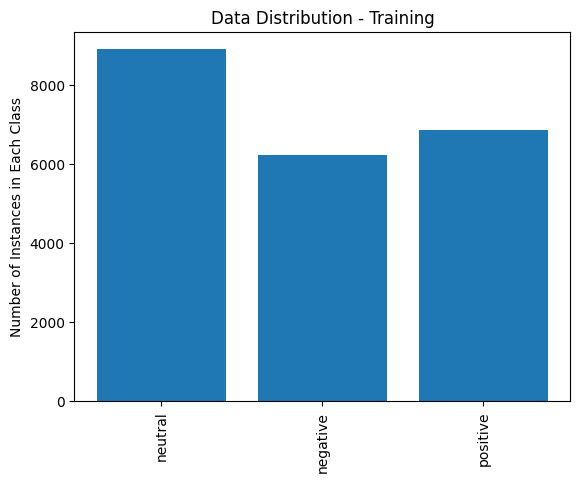

In [16]:
%matplotlib inline

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(
    X, 
    y_ohe, 
    test_size=0.2,
    stratify=df_training.sentiment,
    random_state=42
)


# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe, axis=0)
plt.bar(list(range(NUM_CLASSES)),uniq_classes)
plt.xticks(list(range(NUM_CLASSES)), target_names, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.title("Data Distribution - Training")
plt.show()

## Glove Embedding Loading

In [17]:
!ls -a "./Glove/" 

.   .ipynb_checkpoints	glove.6B.200d.txt  glove.6B.50d.txt
..  glove.6B.100d.txt	glove.6B.300d.txt


In [18]:
%%time

EMBED_SIZE = 100

# the embed size should match the file you load glove from
embeddings_index = {}
f = open('./Glove/glove.6B.100d.txt')

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print(
    "Embedding Shape:", embedding_matrix.shape, "\n",
    "Total words found:", found_words, "\n",
    "Percentage:", 100*found_words/embedding_matrix.shape[0]
)

Found 235487 word vectors.
Embedding Shape: (26599, 100) 
 Total words found: 17532 
 Percentage: 65.91225234031354
CPU times: user 3.3 s, sys: 178 ms, total: 3.48 s
Wall time: 3.43 s


## Modeling

### CNN

#### CNN A

3 Convolutional layers and 1 Hidden Dense Layer
  * First layer: 128 filters with 5 kernel size
  * MaxPooling1D with pool size 2
  * Dropout 20%
  * Second layer: 128 filters with 5 kernel size
  * MaxPooling1D with pool size 2
  * Dropout 20%
  * Third layer: 128 filters with 5 kernel size
  * MaxPooling1D with pool size 2
  * Flatten
  * Dropout 20%
  * Hidden Dense with 128 neurons

#### CNN B

3 Convolutional layers and 1 Hidden Dense Layer
  * <First layer: 128 filters with <font color='red'>3 kernel size</font>
  * MaxPooling1D with pool size 2
  * Dropout 20%
  * Second layer: 128 filters with <font color='red'>6 kernel size</font>
  * MaxPooling1D with <font color='red'>pool size 4</font>
  * Dropout 20%
  * Third layer: 128 filters with 5 kernel size
  * MaxPooling1D with pool size 2
  * Flatten
  * Dropout 20%
  * Hidden Dense with 128 neurons

In [19]:
from tensorflow.keras import backend as K

def fbeta_local(y_true, y_pred, beta=2.0):
    y_pred = K.clip(y_pred, 0, 1)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # a
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1))) # d
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1))) 
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    
    percision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    num = (1 + (beta ** 2)) * percision * recall
    den =  ((beta ** 2) * percision) + recall + K.epsilon()
    return num / den

In [20]:
def plot_results(combined_dict, metric):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(combined_dict[metric])
    plt.plot(combined_dict['val_{}'.format(metric)])
    plt.title('Model {}'.format(metric))
    plt.ylabel('fbeta')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(combined_dict['loss'])
    plt.plot(combined_dict['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [22]:
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix],# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input) # from previous embedding

x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 140-4=136
x = MaxPooling1D(2)(x)# after max pool, 136/2 = 68
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 68-4=64
x = MaxPooling1D(2)(x) # after max pool, size is 64/2 = 32
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 32-4=28
x = MaxPooling1D(2)(x) # after max pool, size is 28/2 = 14

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_a = Model(sequence_input, preds)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model_cnn_a.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc', fbeta_local])

print(model_cnn_a.summary())
histories = []
tmp = model_cnn_a.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 100)          2659900   
                                                                 
 conv1d (Conv1D)             (None, 136, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 68, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 128)           82048     
                                                             

2023-12-13 04:04:15.851314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


172/172 [==============================] - 7s 37ms/step - loss: 1.0617 - acc: 0.4300 - fbeta_local: 0.0945 - val_loss: 0.9210 - val_acc: 0.5672 - val_fbeta_local: 0.3326
Epoch 2/2
172/172 [==============================] - 6s 34ms/step - loss: 0.8476 - acc: 0.6140 - fbeta_local: 0.5053 - val_loss: 0.7722 - val_acc: 0.6640 - val_fbeta_local: 0.5808


In [23]:
tmp = model_cnn_a.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
                epochs=10, batch_size=128)
histories.append(tmp)

Epoch 1/10
172/172 [==============================] - 6s 34ms/step - loss: 0.7468 - acc: 0.6793 - fbeta_local: 0.6194 - val_loss: 0.7359 - val_acc: 0.6811 - val_fbeta_local: 0.6254
Epoch 2/10
172/172 [==============================] - 6s 35ms/step - loss: 0.6905 - acc: 0.7057 - fbeta_local: 0.6593 - val_loss: 0.7268 - val_acc: 0.6915 - val_fbeta_local: 0.6453
Epoch 3/10
172/172 [==============================] - 6s 34ms/step - loss: 0.6530 - acc: 0.7234 - fbeta_local: 0.6815 - val_loss: 0.7324 - val_acc: 0.6866 - val_fbeta_local: 0.6367
Epoch 4/10
172/172 [==============================] - 6s 32ms/step - loss: 0.6205 - acc: 0.7429 - fbeta_local: 0.7043 - val_loss: 0.7223 - val_acc: 0.6887 - val_fbeta_local: 0.6525
Epoch 5/10
172/172 [==============================] - 6s 34ms/step - loss: 0.5777 - acc: 0.7625 - fbeta_local: 0.7329 - val_loss: 0.7673 - val_acc: 0.6880 - val_fbeta_local: 0.6667
Epoch 6/10
172/172 [==============================] - 6s 32ms/step - loss: 0.5463 - acc: 0.7783

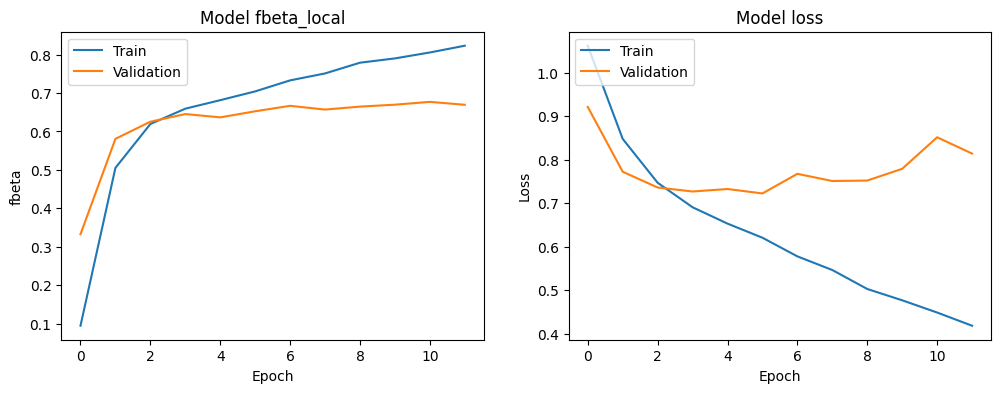

In [24]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','fbeta_local', 'val_fbeta_local', 'loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
plot_results(combined, 'fbeta_local')

In [25]:
embedding_layer = Embedding(
    len(word_index) + 1,
    EMBED_SIZE,
    weights=[embedding_matrix],# here is the embedding getting saved
    input_length=MAX_ART_LEN,
    trainable=False
)

sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')

embedded_sequences = embedding_layer(sequence_input) # from previous embedding

x = Conv1D(128, 3, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 140-2=138
x = MaxPooling1D(2)(x)# after max pool, 138/2 = 69
x = Dropout(0.2)(x)
x = Conv1D(128, 6, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 69-5=64
x = MaxPooling1D(4)(x) # after max pool, size is 64/4 = 16
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 16-4=12
x = MaxPooling1D(2)(x) # after max pool, size is 12/2 = 6

x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_cnn_b = Model(sequence_input, preds)
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 

opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
model_cnn_b.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc', fbeta_local])

print(model_cnn_a.summary())
histories = []
tmp = model_cnn_b.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=2, batch_size=128)
histories.append(tmp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 140)]             0         
                                                                 
 embedding (Embedding)       (None, 140, 100)          2659900   
                                                                 
 conv1d (Conv1D)             (None, 136, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 68, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 68, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 128)           82048     
                                                             

In [26]:
tmp = model_cnn_b.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
                epochs=10, batch_size=128)
histories.append(tmp)

Epoch 1/10
172/172 [==============================] - 5s 30ms/step - loss: 0.7273 - acc: 0.6883 - fbeta_local: 0.6299 - val_loss: 0.7249 - val_acc: 0.6842 - val_fbeta_local: 0.6174
Epoch 2/10
172/172 [==============================] - 5s 30ms/step - loss: 0.6855 - acc: 0.7080 - fbeta_local: 0.6608 - val_loss: 0.7022 - val_acc: 0.7022 - val_fbeta_local: 0.6492
Epoch 3/10
172/172 [==============================] - 5s 30ms/step - loss: 0.6516 - acc: 0.7268 - fbeta_local: 0.6829 - val_loss: 0.6981 - val_acc: 0.7007 - val_fbeta_local: 0.6604
Epoch 4/10
172/172 [==============================] - 5s 30ms/step - loss: 0.6190 - acc: 0.7439 - fbeta_local: 0.7071 - val_loss: 0.7033 - val_acc: 0.7053 - val_fbeta_local: 0.6720
Epoch 5/10
172/172 [==============================] - 5s 30ms/step - loss: 0.5899 - acc: 0.7548 - fbeta_local: 0.7243 - val_loss: 0.7220 - val_acc: 0.6989 - val_fbeta_local: 0.6771
Epoch 6/10
172/172 [==============================] - 5s 30ms/step - loss: 0.5621 - acc: 0.7659

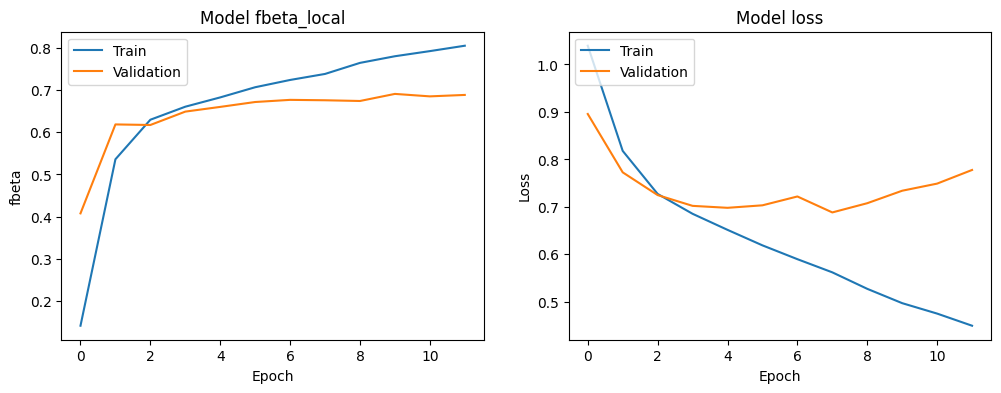

In [27]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','fbeta_local', 'val_fbeta_local', 'loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
plot_results(combined, 'fbeta_local')

### Transformer

#### Transformer A

* 4 Attention heads
* 32 Hidden layers in FF network
* Embedded size 100

#### Transformer B

* 4 Attention heads
* 32 Hidden layers in FF network
* <font color='red'>Embedded size 200</font>

In [30]:
# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(input_dim=vocab_size, 
                                   output_dim=embed_dim)
        # another embedding for processing the position
        self.pos_emb = Embedding(input_dim=maxlen, 
                                 output_dim=embed_dim)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [31]:
# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 EMBED_SIZE, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [40]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_transformer_a = Model(inputs=inputs, outputs=preds)
print(model_transformer_a.summary())

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 140)]             0         
                                                                 
 glove_token_and_position_em  (None, 140, 100)         2673900   
 bedding_4 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_4 (Transf  (None, 140, 100)         168232    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_4   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_24 (Dropout)        (None, 100)               0   

In [ ]:
model_transformer_a.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc', fbeta_local])
histories = []
tmp = model_transformer_a.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=16)
histories.append(tmp)

Epoch 1/6
1374/1374 [==============================] - 72s 51ms/step - loss: 0.9094 - acc: 0.5701 - fbeta_local: 0.4360 - val_loss: 0.7550 - val_acc: 0.6855 - val_fbeta_local: 0.6453
Epoch 2/6
1374/1374 [==============================] - 72s 52ms/step - loss: 0.7642 - acc: 0.6876 - fbeta_local: 0.6285 - val_loss: 0.7287 - val_acc: 0.6958 - val_fbeta_local: 0.6652
Epoch 3/6
1374/1374 [==============================] - 70s 51ms/step - loss: 0.7296 - acc: 0.6976 - fbeta_local: 0.6416 - val_loss: 0.7032 - val_acc: 0.7038 - val_fbeta_local: 0.6433
Epoch 4/6
1374/1374 [==============================] - 71s 51ms/step - loss: 0.7087 - acc: 0.7100 - fbeta_local: 0.6574 - val_loss: 0.7624 - val_acc: 0.7095 - val_fbeta_local: 0.6726
Epoch 5/6
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6985 - acc: 0.7116 - fbeta_local: 0.6581 - val_loss: 0.6922 - val_acc: 0.7158 - val_fbeta_local: 0.6612
Epoch 6/6
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6935 -

In [43]:
%%time 

tmp = model_transformer_a.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6863 - acc: 0.7184 - fbeta_local: 0.6683 - val_loss: 0.6911 - val_acc: 0.7197 - val_fbeta_local: 0.6778
Epoch 2/8
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6784 - acc: 0.7221 - fbeta_local: 0.6720 - val_loss: 0.6950 - val_acc: 0.7111 - val_fbeta_local: 0.6731
Epoch 3/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6688 - acc: 0.7264 - fbeta_local: 0.6789 - val_loss: 0.7239 - val_acc: 0.7186 - val_fbeta_local: 0.6907
Epoch 4/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6652 - acc: 0.7281 - fbeta_local: 0.6830 - val_loss: 0.6772 - val_acc: 0.7206 - val_fbeta_local: 0.6749
Epoch 5/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6614 - acc: 0.7316 - fbeta_local: 0.6845 - val_loss: 0.7236 - val_acc: 0.7253 - val_fbeta_local: 0.7016
Epoch 6/8
1374/1374 [==============================] - 72s 53ms/step - loss: 0.6585 -

In [46]:
%%time 

tmp = model_transformer_a.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6527 - acc: 0.7364 - fbeta_local: 0.6867 - val_loss: 0.6937 - val_acc: 0.7231 - val_fbeta_local: 0.6681
Epoch 2/8
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6503 - acc: 0.7359 - fbeta_local: 0.6908 - val_loss: 0.6984 - val_acc: 0.7173 - val_fbeta_local: 0.6682
Epoch 3/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6482 - acc: 0.7376 - fbeta_local: 0.6910 - val_loss: 0.7048 - val_acc: 0.7209 - val_fbeta_local: 0.6838
Epoch 4/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6449 - acc: 0.7382 - fbeta_local: 0.6938 - val_loss: 0.6965 - val_acc: 0.7218 - val_fbeta_local: 0.6808
Epoch 5/8
1374/1374 [==============================] - 71s 52ms/step - loss: 0.6414 - acc: 0.7398 - fbeta_local: 0.6897 - val_loss: 0.7156 - val_acc: 0.7066 - val_fbeta_local: 0.6433
Epoch 6/8
1374/1374 [==============================] - 72s 52ms/step - loss: 0.6408 -

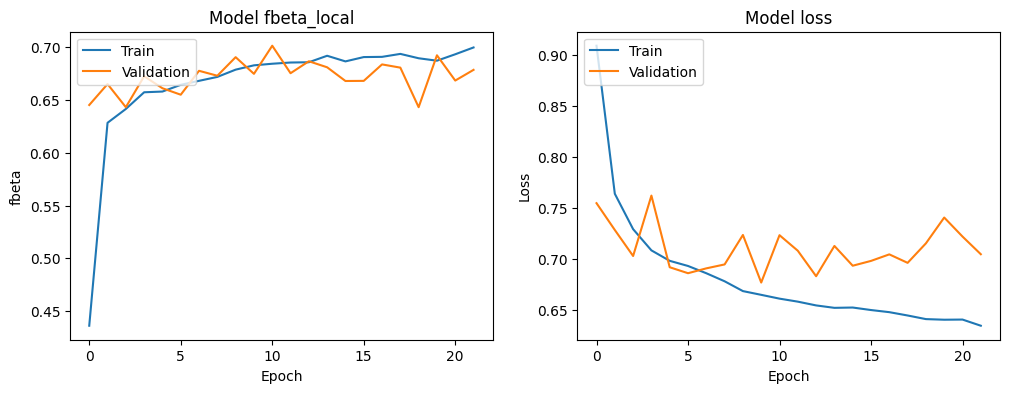

In [47]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','fbeta_local', 'val_fbeta_local', 'loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
plot_results(combined, 'fbeta_local')

In [53]:
# first, let's replace the original embedding in the xformer
# with our custom GloVe embedding

class GloveTokenAndPositionEmbedding_2(Layer):
    def __init__(self, embed_size, embedding_matrix_tmp):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens, pretrained (words)
        self.token_emb = Embedding(len(word_index) + 1,
                            embed_size,
                            weights=[embedding_matrix_tmp],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)
        
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_ART_LEN, 
                                 embed_size, 
                                 input_length=MAX_ART_LEN,
                                 trainable=True
                                )

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [54]:
EMBED_SIZE_2 = 200
# the embed size should match the file you load glove from
embeddings_index_2 = {}
f = open('./Glove/glove.6B.200d.txt')

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index_2[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index_2))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix_2 = np.zeros((len(word_index) + 1, EMBED_SIZE_2))
for word, i in word_index.items():
    embedding_vector_2 = embeddings_index_2.get(word)
    if embedding_vector_2 is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix_2[i] = embedding_vector_2
        found_words = found_words+1

print(
    "Embedding Shape:", embedding_matrix_2.shape, "\n",
    "Total words found:", found_words, "\n",
    "Percentage:", 100*found_words/embedding_matrix_2.shape[0]
)


Found 116899 word vectors.
Embedding Shape: (26599, 200) 
 Total words found: 16072 
 Percentage: 60.42332418511974


In [55]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding_2(EMBED_SIZE_2, embedding_matrix_2)(inputs)
x = TransformerBlock(EMBED_SIZE_2, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_transformer_b = Model(inputs=inputs, outputs=preds)
print(model_transformer_b.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 140)]             0         
                                                                 
 glove_token_and_position_em  (None, 140, 200)         5347800   
 bedding_2_1 (GloveTokenAndP                                     
 ositionEmbedding_2)                                             
                                                                 
 transformer_block_6 (Transf  (None, 140, 200)         656432    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_5   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_30 (Dropout)        (None, 200)               0   

In [57]:
model_transformer_b.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc', fbeta_local])
histories = []
tmp = model_transformer_b.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=16)
histories.append(tmp)

Epoch 1/6
1374/1374 [==============================] - 100s 72ms/step - loss: 0.7337 - acc: 0.6978 - fbeta_local: 0.6408 - val_loss: 0.7669 - val_acc: 0.7007 - val_fbeta_local: 0.6658
Epoch 2/6
1374/1374 [==============================] - 99s 72ms/step - loss: 0.7099 - acc: 0.7096 - fbeta_local: 0.6594 - val_loss: 0.7054 - val_acc: 0.6949 - val_fbeta_local: 0.6636
Epoch 3/6
1374/1374 [==============================] - 97s 71ms/step - loss: 0.6965 - acc: 0.7163 - fbeta_local: 0.6668 - val_loss: 0.6903 - val_acc: 0.7169 - val_fbeta_local: 0.6722
Epoch 4/6
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6900 - acc: 0.7200 - fbeta_local: 0.6687 - val_loss: 0.6758 - val_acc: 0.7229 - val_fbeta_local: 0.6837
Epoch 5/6
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6779 - acc: 0.7227 - fbeta_local: 0.6731 - val_loss: 0.7021 - val_acc: 0.7160 - val_fbeta_local: 0.6646
Epoch 6/6
1374/1374 [==============================] - 100s 72ms/step - loss: 0.6715

In [61]:
%%time 

tmp = model_transformer_b.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6628 - acc: 0.7279 - fbeta_local: 0.6819 - val_loss: 0.7002 - val_acc: 0.7002 - val_fbeta_local: 0.6079
Epoch 2/8
1374/1374 [==============================] - 100s 73ms/step - loss: 0.6582 - acc: 0.7300 - fbeta_local: 0.6816 - val_loss: 0.7218 - val_acc: 0.7029 - val_fbeta_local: 0.6553
Epoch 3/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6537 - acc: 0.7314 - fbeta_local: 0.6863 - val_loss: 0.7194 - val_acc: 0.7158 - val_fbeta_local: 0.6786
Epoch 4/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6483 - acc: 0.7343 - fbeta_local: 0.6909 - val_loss: 0.7164 - val_acc: 0.7246 - val_fbeta_local: 0.6896
Epoch 5/8
1374/1374 [==============================] - 98s 72ms/step - loss: 0.6439 - acc: 0.7382 - fbeta_local: 0.6925 - val_loss: 0.7412 - val_acc: 0.7131 - val_fbeta_local: 0.6834
Epoch 6/8
1374/1374 [==============================] - 100s 73ms/step - loss: 0.6397

In [63]:
%%time 

tmp = model_transformer_b.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6292 - acc: 0.7431 - fbeta_local: 0.6996 - val_loss: 0.7891 - val_acc: 0.7102 - val_fbeta_local: 0.6857
Epoch 2/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6268 - acc: 0.7458 - fbeta_local: 0.7067 - val_loss: 0.7340 - val_acc: 0.7218 - val_fbeta_local: 0.7000
Epoch 3/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6249 - acc: 0.7483 - fbeta_local: 0.7068 - val_loss: 0.7901 - val_acc: 0.6989 - val_fbeta_local: 0.6693
Epoch 4/8
1374/1374 [==============================] - 100s 72ms/step - loss: 0.6198 - acc: 0.7470 - fbeta_local: 0.7028 - val_loss: 0.7512 - val_acc: 0.7211 - val_fbeta_local: 0.7038
Epoch 5/8
1374/1374 [==============================] - 100s 73ms/step - loss: 0.6222 - acc: 0.7494 - fbeta_local: 0.7067 - val_loss: 0.7387 - val_acc: 0.7184 - val_fbeta_local: 0.6869
Epoch 6/8
1374/1374 [==============================] - 99s 72ms/step - loss: 0.6178

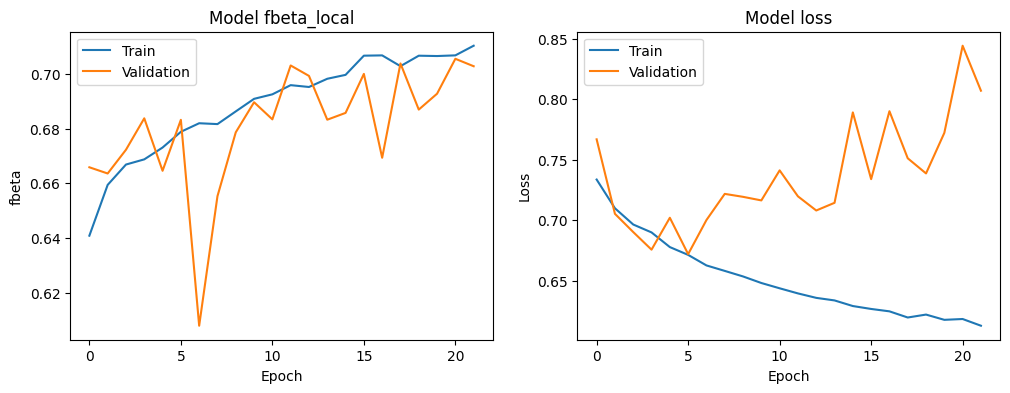

In [65]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','fbeta_local', 'val_fbeta_local', 'loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
plot_results(combined, 'fbeta_local')

### Add a second Multi-headed self attention

In [66]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBED_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_transformer_c = Model(inputs=inputs, outputs=preds)
print(model_transformer_c.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 140)]             0         
                                                                 
 glove_token_and_position_em  (None, 140, 100)         2673900   
 bedding_6 (GloveTokenAndPos                                     
 itionEmbedding)                                                 
                                                                 
 transformer_block_7 (Transf  (None, 140, 100)         168232    
 ormerBlock)                                                     
                                                                 
 transformer_block_8 (Transf  (None, 140, 100)         168232    
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_6   (None, 100)              0   

In [67]:
model_transformer_c.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc', fbeta_local])
histories = []
tmp = model_transformer_c.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=6, batch_size=16)
histories.append(tmp)

Epoch 1/6
1374/1374 [==============================] - 140s 101ms/step - loss: 0.9245 - acc: 0.5672 - fbeta_local: 0.4256 - val_loss: 0.8371 - val_acc: 0.6282 - val_fbeta_local: 0.5781
Epoch 2/6
1374/1374 [==============================] - 139s 101ms/step - loss: 0.7668 - acc: 0.6858 - fbeta_local: 0.6234 - val_loss: 0.7406 - val_acc: 0.6889 - val_fbeta_local: 0.6251
Epoch 3/6
1374/1374 [==============================] - 138s 100ms/step - loss: 0.7395 - acc: 0.6910 - fbeta_local: 0.6370 - val_loss: 0.7264 - val_acc: 0.6924 - val_fbeta_local: 0.6541
Epoch 4/6
1374/1374 [==============================] - 138s 100ms/step - loss: 0.7158 - acc: 0.7050 - fbeta_local: 0.6504 - val_loss: 0.7001 - val_acc: 0.7131 - val_fbeta_local: 0.6400
Epoch 5/6
1374/1374 [==============================] - 139s 101ms/step - loss: 0.7089 - acc: 0.7117 - fbeta_local: 0.6569 - val_loss: 0.7450 - val_acc: 0.6960 - val_fbeta_local: 0.6436
Epoch 6/6
1374/1374 [==============================] - 138s 101ms/step - lo

In [69]:
%%time 

tmp = model_transformer_c.fit(X_train, y_train_ohe, 
                validation_data=(X_test, y_test_ohe),
               epochs=8, batch_size=16)
histories.append(tmp)

Epoch 1/8
1374/1374 [==============================] - 138s 101ms/step - loss: 0.6953 - acc: 0.7166 - fbeta_local: 0.6687 - val_loss: 0.7077 - val_acc: 0.7146 - val_fbeta_local: 0.6654
Epoch 2/8
1374/1374 [==============================] - 138s 101ms/step - loss: 0.6843 - acc: 0.7262 - fbeta_local: 0.6754 - val_loss: 0.7084 - val_acc: 0.7133 - val_fbeta_local: 0.6941
Epoch 3/8
1374/1374 [==============================] - 139s 101ms/step - loss: 0.6794 - acc: 0.7283 - fbeta_local: 0.6778 - val_loss: 0.7025 - val_acc: 0.7228 - val_fbeta_local: 0.6957
Epoch 4/8
1374/1374 [==============================] - 138s 100ms/step - loss: 0.6692 - acc: 0.7290 - fbeta_local: 0.6792 - val_loss: 0.7748 - val_acc: 0.6975 - val_fbeta_local: 0.6546
Epoch 5/8
1374/1374 [==============================] - 139s 101ms/step - loss: 0.6644 - acc: 0.7349 - fbeta_local: 0.6890 - val_loss: 0.6892 - val_acc: 0.7251 - val_fbeta_local: 0.6830
Epoch 6/8
1374/1374 [==============================] - 138s 101ms/step - lo

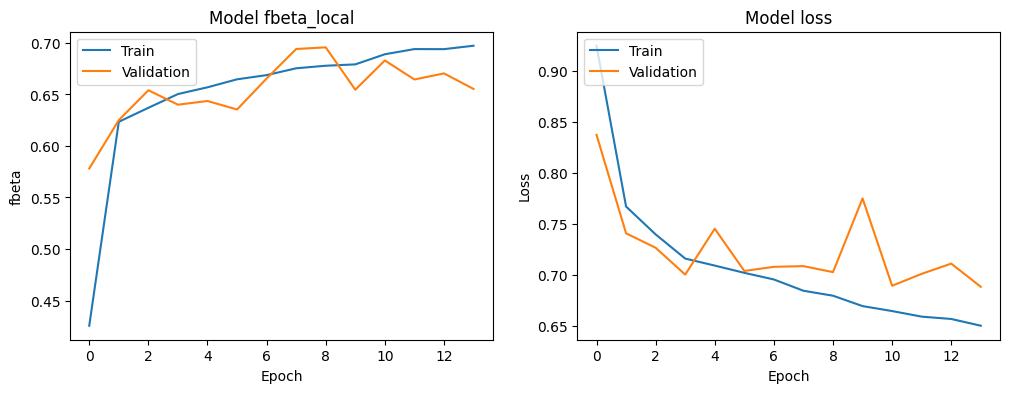

In [70]:
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','fbeta_local', 'val_fbeta_local', 'loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
plot_results(combined, 'fbeta_local')

### Compare all models

In [74]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

def model_evaluate(model): 
    # predict class with test set
    y_pred_test =  np.argmax(model.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test_ohe,axis=1),y_pred_test)*100))
    
    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test_ohe,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test_ohe,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()


#### CNN - A

172/172 [==============================] - 1s 4ms/step
Accuracy:	68.7%


              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2224
           1       0.68      0.67      0.68      1556
           2       0.74      0.71      0.73      1717

    accuracy                           0.69      5497
   macro avg       0.69      0.69      0.69      5497
weighted avg       0.69      0.69      0.69      5497



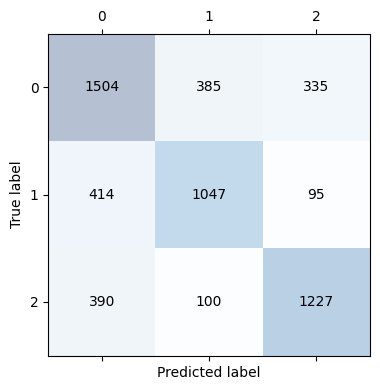

In [76]:
model_evaluate(model_cnn_a)

#### CNN - B

172/172 [==============================] - 1s 3ms/step
Accuracy:	70.5%


              precision    recall  f1-score   support

           0       0.65      0.73      0.69      2224
           1       0.75      0.63      0.69      1556
           2       0.75      0.74      0.74      1717

    accuracy                           0.70      5497
   macro avg       0.72      0.70      0.71      5497
weighted avg       0.71      0.70      0.71      5497



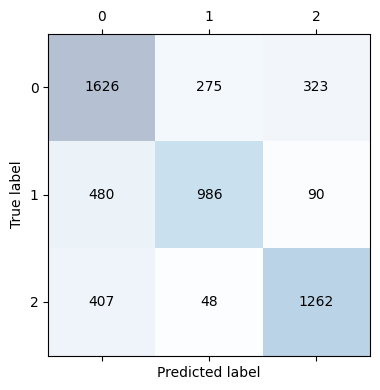

In [77]:
model_evaluate(model_cnn_b)

#### Transformer - A

172/172 [==============================] - 7s 39ms/step
Accuracy:	71.7%


              precision    recall  f1-score   support

           0       0.67      0.75      0.71      2224
           1       0.71      0.67      0.69      1556
           2       0.79      0.72      0.75      1717

    accuracy                           0.72      5497
   macro avg       0.73      0.71      0.72      5497
weighted avg       0.72      0.72      0.72      5497



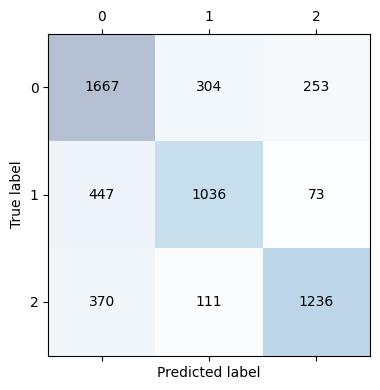

In [79]:
model_evaluate(model_transformer_a)

#### Transformer - B

172/172 [==============================] - 9s 53ms/step
Accuracy:	71.5%


              precision    recall  f1-score   support

           0       0.65      0.79      0.71      2224
           1       0.80      0.57      0.66      1556
           2       0.76      0.76      0.76      1717

    accuracy                           0.72      5497
   macro avg       0.74      0.70      0.71      5497
weighted avg       0.73      0.72      0.71      5497



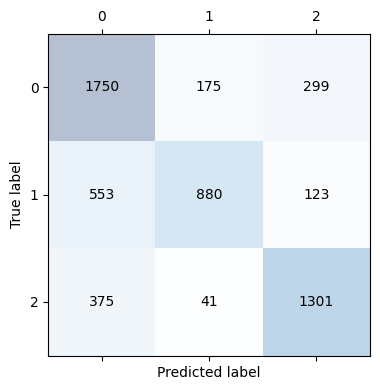

In [80]:
model_evaluate(model_transformer_b)

#### Transformer - C - Extra Multi headed self attention

172/172 [==============================] - 13s 78ms/step
Accuracy:	71.9%


              precision    recall  f1-score   support

           0       0.70      0.69      0.70      2224
           1       0.67      0.74      0.70      1556
           2       0.80      0.73      0.77      1717

    accuracy                           0.72      5497
   macro avg       0.72      0.72      0.72      5497
weighted avg       0.72      0.72      0.72      5497



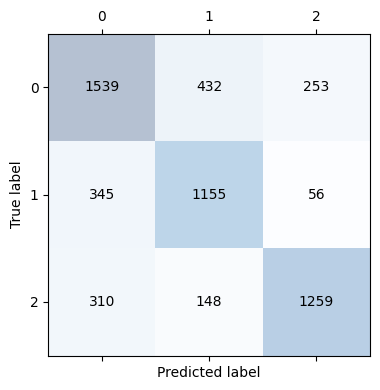

In [78]:
model_evaluate(model_transformer_c)

#### Statistical Comparision

In [83]:
def get_variance_subtracted_error_states(n_1, error_1, n_2, error_2):
    one = (error_1 * (1 - error_1)) / n_1
    two = (error_2 * (1 - error_2)) / n_2
    return one + two

def get_mean_difference(error_1, error_2):
    return abs(error_1 - error_2)

##### Comparing the 2 CNNs

In [86]:
cnn_a_error_avg = 0.7771
cnn_b_error_avg = 0.7400

segma = get_variance_subtracted_error_states(
    5497, 
    cnn_a_error_avg,
    5497, 
    cnn_b_error_avg
)

d = get_mean_difference(cnn_a_error_avg, cnn_b_error_avg)

print('CNN A Error Avg {}'.format(cnn_a_error_avg))
print('CNN B Error Avg {}'.format(cnn_b_error_avg))
print('Confidence Range of: {} , {}'.format(d-segma, d+segma))

CNN A Error Avg 0.7771
CNN B Error Avg 0.74
Confidence Range of: 0.03703348815899584 , 0.0371665118410042


Given the range does not include 0.0 -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. Given higher FBeta Accuracy of CNN B we can say it is statistically better.

##### Comparing the 2 Transformers A & B

In [89]:
transformer_a_error_avg = 0.7100
transformer_b_error_avg = 0.7358

segma = get_variance_subtracted_error_states(
    5497, 
    transformer_a_error_avg,
    5497, 
    transformer_b_error_avg
)

d = get_mean_difference(transformer_a_error_avg, transformer_b_error_avg)

print('Transformer A Error Avg {}'.format(transformer_a_error_avg))
print('Transformer B Error Avg {}'.format(transformer_b_error_avg))
print('Confidence Range of: {} , {}'.format(d-segma, d+segma))

Transformer A Error Avg 0.71
Transformer B Error Avg 0.7358
Confidence Range of: 0.025727178759323312 , 0.025872821240676778


Given the range does not include 0.0 -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. Given higher FBeta Accuracy of Transformer A we can say it is statistically better.

##### Comparing CNN B and Transformer A

In [90]:
transformer_a_error_avg = 0.7100
cnn_b_error_avg = 0.7400

segma = get_variance_subtracted_error_states(
    5497, 
    transformer_a_error_avg,
    5497, 
    cnn_b_error_avg
)

d = get_mean_difference(transformer_a_error_avg, cnn_b_error_avg)

print('Transformer A Error Avg {}'.format(transformer_a_error_avg))
print('CNN B Error Avg {}'.format(cnn_b_error_avg))
print('Confidence Range of: {} , {}'.format(d-segma, d+segma))

Transformer A Error Avg 0.71
CNN B Error Avg 0.74
Confidence Range of: 0.029927542295797735 , 0.03007245770420232


Given the range does not include 0.0 -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other. Given higher FBeta Accuracy of Transformer A we can say it is statistically better.

##### Comparing Transfomer A and Transformer C

In [91]:
transformer_a_error_avg = 0.7100
transformer_c_error_avg = 0.7240

segma = get_variance_subtracted_error_states(
    5497, 
    transformer_a_error_avg,
    5497, 
    transformer_c_error_avg
)

d = get_mean_difference(transformer_a_error_avg, transformer_c_error_avg)

print('Transformer A Error Avg {}'.format(transformer_a_error_avg))
print('Transformer C Error Avg {}'.format(transformer_c_error_avg))
print('Confidence Range of: {} , {}'.format(d-segma, d+segma))

Transformer A Error Avg 0.71
Transformer C Error Avg 0.724
Confidence Range of: 0.013926191740949622 , 0.014073808259050403


Given the range does not include 0.0 -> Thus we can say with statistical confidence that these estimates are different from one another -> Thus one of them is better than the other.